In [107]:
#MLND capstone project by Renato Pedroso
# Jan 19th, 2018
# predicting max/min bitcoin's price

import pandas, numpy
from datetime import datetime
from globalConfig import *
from IPython.display import HTML, display

# fix random seed for reproducibility
numpy.random.seed(13)

#### DATA DISCOVERY / DATA PREPARATION
#Reading the raw data and separating in the max / min values per day
inputFile = FILE_LOCATION + 'all' + CRYPTO_CURRENCY + REAL_CURRENCY
dateparse = lambda dates: pandas.datetime.strptime(str(datetime.fromtimestamp(float(dates)/1000.0))[0:10].replace('-',''), '%Y%m%d')
rawData = pandas.read_csv(inputFile, parse_dates=True, index_col='TIMESTAMP',date_parser=dateparse)

#general pourpose pandas indexed data frame
aggData = rawData.groupby(['TIMESTAMP']).agg({'PRICE':['min', 'max']})

# min and max data to fit arima
aggDataArimaMin = aggData['PRICE']['min']
aggDataArimaMax = aggData['PRICE']['max']
#min and max data, as numpy matrix, to fit LSTM
aggDataLSTMMin = aggData['PRICE']['min'].as_matrix()
aggDataLSTMMax = aggData['PRICE']['max'].as_matrix()
#min and max data to fit dummy model
aggDataDummyMin = aggData['PRICE']['min']
aggDataDummyMax = aggData['PRICE']['max']


In [398]:
#simple data description
print aggData.describe()
display(rawData.head())

def reportDataInitial(rawData, aggData, sep = '#', mult = 60):
    print sep * mult
    print 'INITIAL DATA REPORT'
    print 'Raw data row number: ' + str(len(rawData))
    print 'Aggregated data row number: ' + str(len(aggData))
    print 'Maximum date found in the data: ' + str(max(aggData.index))
    print 'Minimum date found in the data: ' + str(min(aggData.index))
    print 'Trim ratio: ' +str(round((float(len(aggData)) / float(len(rawData))) -1.0 * 100.0, 5)) + '%'
    print sep * mult

reportDataInitial(rawData, aggData)

              PRICE              
                min           max
count    811.000000    811.000000
mean    2029.340870   2254.227577
std     3546.642855   4010.583668
min        0.010000     14.537366
25%      116.885000    124.450000
50%      562.000000    594.490000
75%     2403.600000   2563.700000
max    18100.000000  19891.000000


PERIOD       RATE      PRICE
TIMESTAMP                               
2013-01-14    4145   0.272186  14.537366
2013-01-14    4149  20.000000  14.532950
2013-01-15    4161  44.000000  14.524790
2013-01-15    4163  20.000000  14.768570
2013-01-16    4173   0.200000  14.749200

############################################################
INITIAL DATA REPORT
Raw data row number: 24108423
Aggregated data row number: 811
Maximum date found in the data: 2018-01-24 00:00:00
Minimum date found in the data: 2013-01-14 00:00:00
Trim ratio: -99.99997%
############################################################


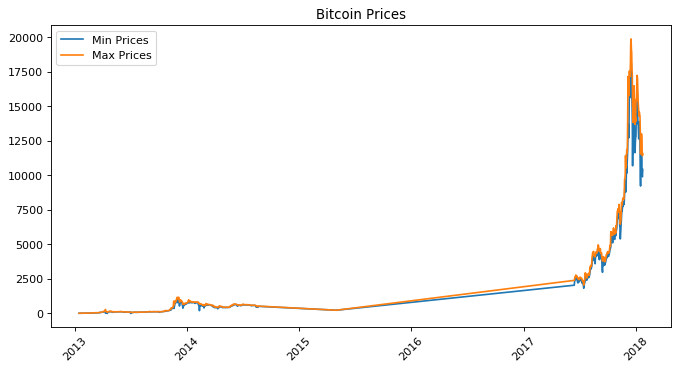

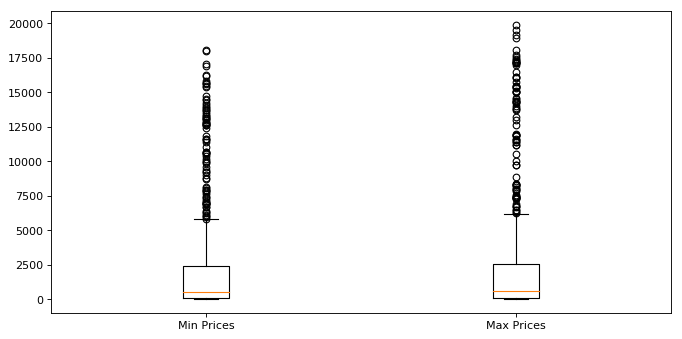

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
dateTicks = [ datetime.strptime(str(i)[0:10], '%Y-%m-%d') for i in aggData.index.values ]
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Bitcoin Prices")
plt.plot(dateTicks, aggDataArimaMin, label='Min Prices')
plt.plot(dateTicks, aggDataArimaMax, label='Max Prices')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show(block=False)

#boxplot graphs
dataToPlot = [aggDataArimaMin, aggDataArimaMax]
fig = plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
bp = ax.boxplot(dataToPlot)
ax.set_xticklabels(['Min Prices', 'Max Prices'])
plt.show()

/home/skineer/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


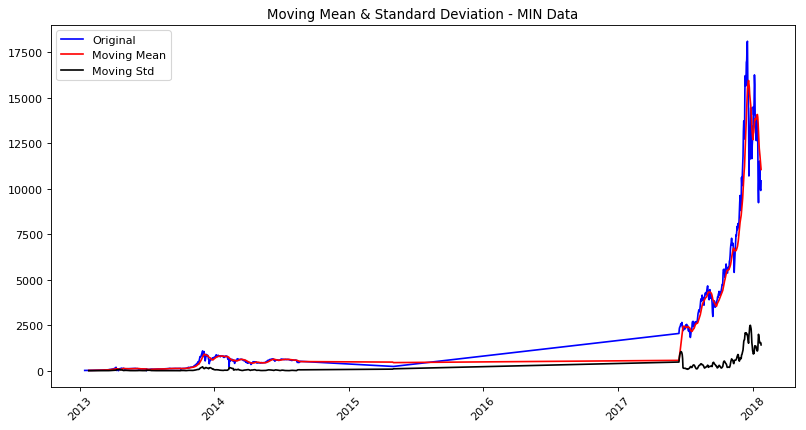

Results of Dickey-Fuller Test:
Test Statistic                   0.033699
p-value                          0.961232
#Lags Used                      19.000000
Number of Observations Used    791.000000
Critical Value (5%)             -2.865201
Critical Value (1%)             -3.438644
Critical Value (10%)            -2.568719
dtype: float64


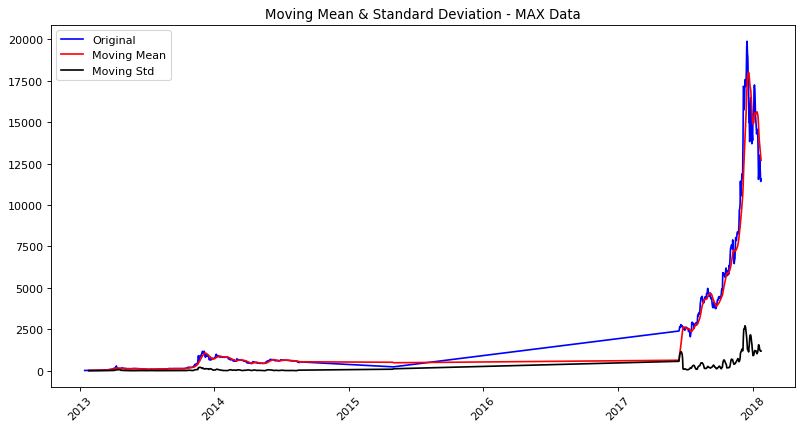

Results of Dickey-Fuller Test:
Test Statistic                  -0.839421
p-value                          0.807267
#Lags Used                      20.000000
Number of Observations Used    790.000000
Critical Value (5%)             -2.865205
Critical Value (1%)             -3.438655
Critical Value (10%)            -2.568722
dtype: float64
################################################################################
THIS IS THE STATIONARITY TEST REPORT
NULL HYPOTHESIS UNSUCCESSFULLY REJECTED FOR DATA MIN. DATA IS NOT STATIONARY
NULL HYPOTHESIS UNSUCCESSFULLY REJECTED FOR DATA MAX. DATA IS NOT STATIONARY
################################################################################


In [6]:
#preparing to fit an ARIMA model for comparison and for future predictions
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

def checkStationarity(timeSeries, labelForGraph, dateTicks, window=12):
    #Determing rolling statistics
    rollingMean = pandas.rolling_mean(timeSeries, window=window)
    rollingStd = pandas.rolling_std(timeSeries, window=window)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
    orig = plt.plot(dateTicks, timeSeries, color='blue',label='Original')
    mean = plt.plot(dateTicks, rollingMean, color='red', label='Moving Mean')
    std = plt.plot(dateTicks, rollingStd, color='black', label = 'Moving Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation - ' + labelForGraph + ' Data')
    plt.xticks(rotation=45)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    #null hypothesis = data is NOT stationary
    #alternative hypothesis = data IS stationary
    #if test statistic < critical values then reject null hypothesis
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeSeries, autolag='AIC')
    dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    return dftest
    # dftest[0] = test statistic
    # dftest[1] = p value
    # dftest[4] = {'5%':value, '1%':value, '10':value}

def stationarityCheckReport(addfullerOutputGathered, dataOrder, sep = '#', mult = 60):
    #addfullerOutputGathered = list of adfuller results
    #dataOrder = list of labels 'MIN' or 'MAX' to print the results
    print sep * mult
    print 'THIS IS THE STATIONARITY TEST REPORT'
    #testing only the p-value to reject null hyphotesis
    for i in range(len(addfullerOutputGathered)):
        if addfullerOutputGathered[i][1] <= 0.05:
            print 'NULL HYPOTHESIS SUCCESSFULLY REJECTED FOR DATA ' + str(dataOrder[i] + '. DATA IS STATIONARY')
        else:
            print 'NULL HYPOTHESIS UNSUCCESSFULLY REJECTED FOR DATA ' + str(dataOrder[i] + '. DATA IS NOT STATIONARY')
    print sep * mult
    
#test stationarity on both datasets    
fullerTestMin = checkStationarity(aggDataArimaMin, 'MIN', dateTicks)
fullerTestMax = checkStationarity(aggDataArimaMax, 'MAX', dateTicks)

#report
stationarityCheckReport([fullerTestMin, fullerTestMax], ['MIN', 'MAX'], mult = 80)

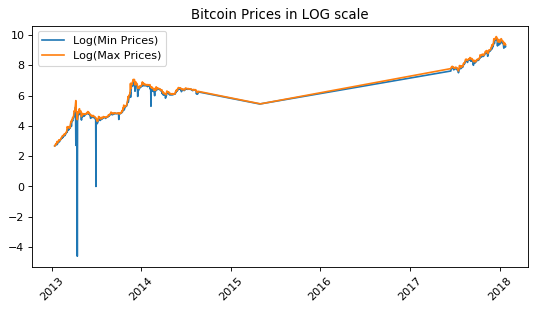

In [7]:
#eliminating trend on the data to make it more stationary
#natural log transformation to reduce skew
aggDataArimaMinLog = numpy.log(aggDataArimaMin)
aggDataArimaMaxLog = numpy.log(aggDataArimaMax)
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Bitcoin Prices in LOG scale")
plt.plot(dateTicks, aggDataArimaMinLog, label='Log(Min Prices)')
plt.plot(dateTicks, aggDataArimaMaxLog, label='Log(Max Prices)')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show(block=False)

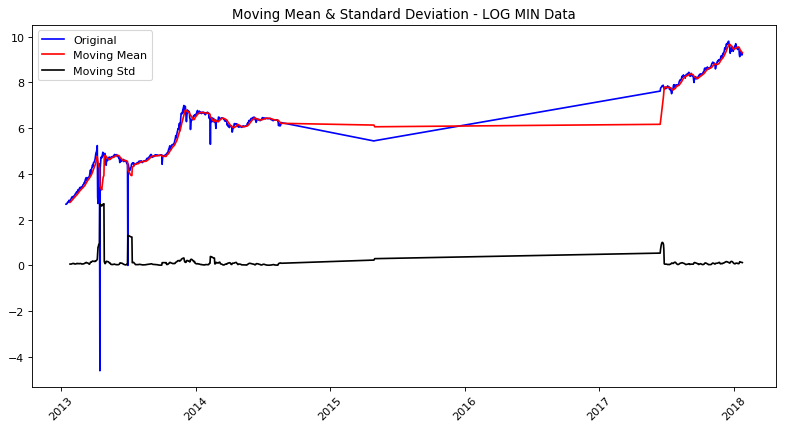

Results of Dickey-Fuller Test:
Test Statistic                  -1.066110
p-value                          0.728396
#Lags Used                      13.000000
Number of Observations Used    797.000000
Critical Value (5%)             -2.865173
Critical Value (1%)             -3.438581
Critical Value (10%)            -2.568705
dtype: float64


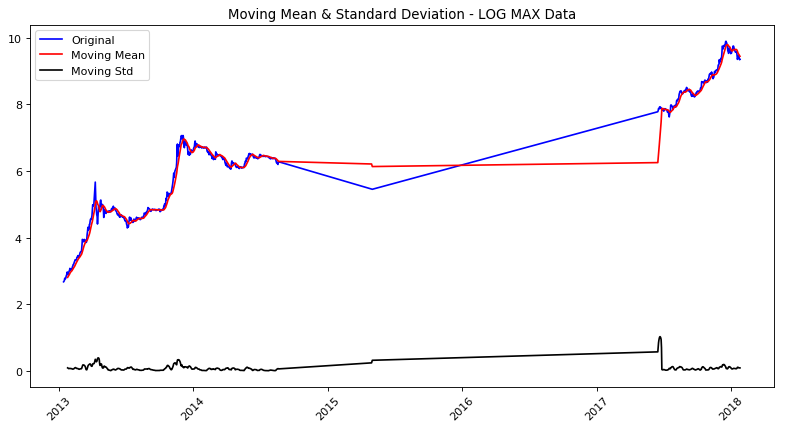

Results of Dickey-Fuller Test:
Test Statistic                  -1.177658
p-value                          0.683132
#Lags Used                       2.000000
Number of Observations Used    808.000000
Critical Value (5%)             -2.865124
Critical Value (1%)             -3.438469
Critical Value (10%)            -2.568678
dtype: float64
############################################################
THIS IS THE STATIONARITY TEST REPORT
NULL HYPOTHESIS UNSUCCESSFULLY REJECTED FOR DATA LOG MIN. DATA IS NOT STATIONARY
NULL HYPOTHESIS UNSUCCESSFULLY REJECTED FOR DATA LOG MAX. DATA IS NOT STATIONARY
############################################################


In [8]:
#check stationarity for log transformation
fullerTestLogMin = checkStationarity(aggDataArimaMinLog, 'LOG MIN', dateTicks)
fullerTestLogMax = checkStationarity(aggDataArimaMaxLog, 'LOG MAX', dateTicks)

stationarityCheckReport([fullerTestLogMin, fullerTestLogMax], ['LOG MIN', 'LOG MAX'])

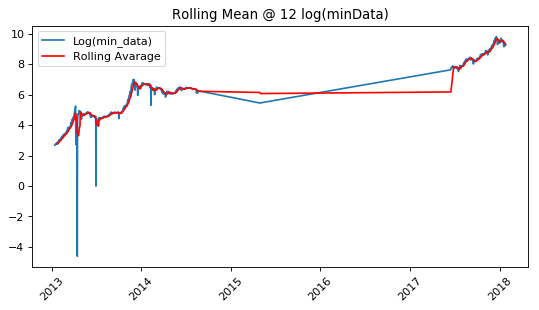

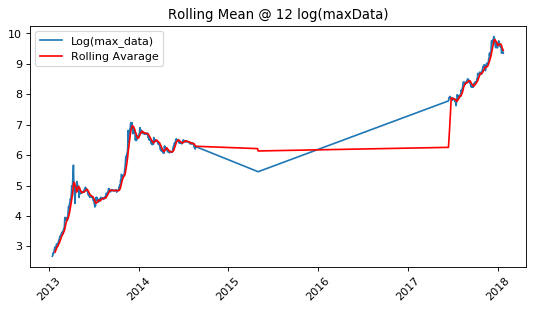

In [9]:
#subtracting the log scale data from the rolling mean 
rollingMeanAggDataArimaMinLog = pandas.rolling_mean(aggDataArimaMinLog,12)
rollingMeanAggDataArimaMaxLog = pandas.rolling_mean(aggDataArimaMaxLog,12)
# plot min values
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Rolling Mean @ 12 log(minData)')
plt.plot(dateTicks, aggDataArimaMinLog, label='Log(min_data)')
plt.plot(dateTicks, rollingMeanAggDataArimaMinLog, color='red', label = 'Rolling Avarage')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

# plot max values
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Rolling Mean @ 12 log(maxData)')
plt.plot(dateTicks, aggDataArimaMaxLog, label='Log(max_data)')
plt.plot(dateTicks, rollingMeanAggDataArimaMaxLog, color='red', label = 'Rolling Avarage')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

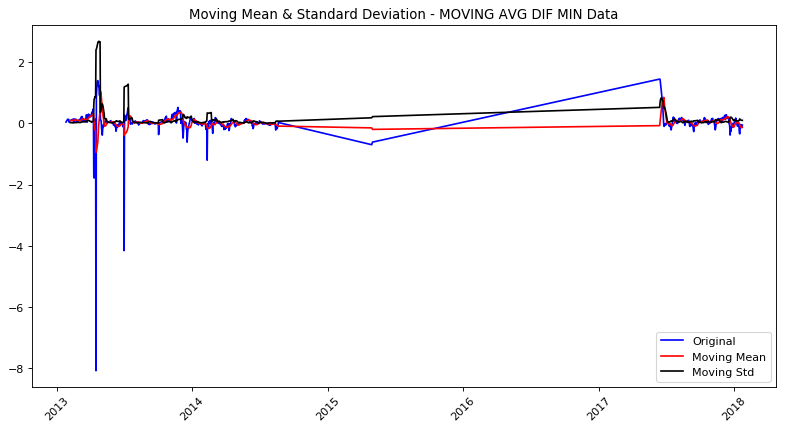

Results of Dickey-Fuller Test:
Test Statistic                -1.069197e+01
p-value                        3.706174e-19
#Lags Used                     1.000000e+01
Number of Observations Used    7.890000e+02
Critical Value (5%)           -2.865210e+00
Critical Value (1%)           -3.438665e+00
Critical Value (10%)          -2.568724e+00
dtype: float64


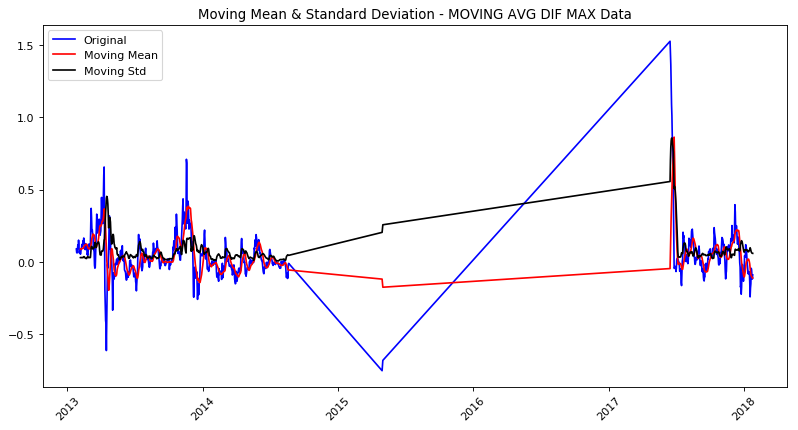

Results of Dickey-Fuller Test:
Test Statistic                -8.219351e+00
p-value                        6.492779e-13
#Lags Used                     5.000000e+00
Number of Observations Used    7.940000e+02
Critical Value (5%)           -2.865187e+00
Critical Value (1%)           -3.438613e+00
Critical Value (10%)          -2.568712e+00
dtype: float64
############################################################
THIS IS THE STATIONARITY TEST REPORT
NULL HYPOTHESIS SUCCESSFULLY REJECTED FOR DATA MOVING AVG DIF MIN. DATA IS STATIONARY
NULL HYPOTHESIS SUCCESSFULLY REJECTED FOR DATA MOVING AVG DIF MAX. DATA IS STATIONARY
############################################################


In [10]:
#subtracting the difference between rolling mean and log(data)
def computeDiffLog(logData, rollingMeanLog, label, dateTicks):
    #logData --> pandas data transformed in log scale
    #rollingMeanLog --> pandas rolling avarage of logData
    movingAvgDiff = logData - rollingMeanLog
    nanCount = movingAvgDiff.isnull().sum()
    movingAvgDiff.dropna(inplace=True)
    fullerResult = checkStationarity(movingAvgDiff, label, dateTicks[nanCount:])
    return fullerResult, movingAvgDiff

meanDiffLogMinFuller, meanDiffLogMinData = computeDiffLog(aggDataArimaMinLog, rollingMeanAggDataArimaMinLog, 'MOVING AVG DIF MIN', dateTicks)
meanDiffLogMaxFuller, meanDiffLogMaxData = computeDiffLog(aggDataArimaMaxLog, rollingMeanAggDataArimaMaxLog, 'MOVING AVG DIF MAX', dateTicks)
stationarityCheckReport([meanDiffLogMinFuller, meanDiffLogMaxFuller], ['MOVING AVG DIF MIN', 'MOVING AVG DIF MAX'])

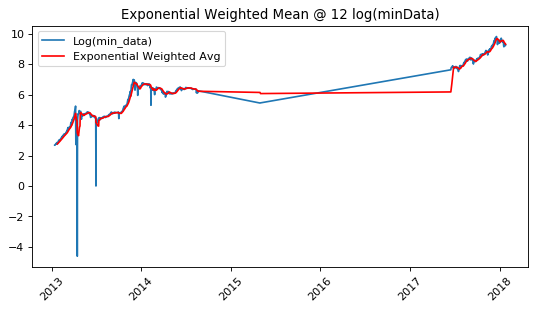

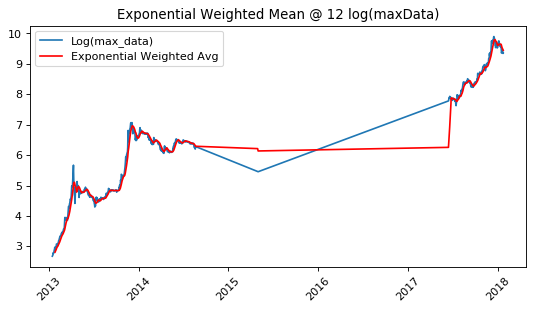

In [11]:
#trying exponential weighted avg to possibly improve stationarity
expMeanAggDataArimaMinLog = pandas.ewma(aggDataArimaMinLog,12)
expMeanAggDataArimaMaxLog = pandas.ewma(aggDataArimaMaxLog,12)

# plot min values
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Exponential Weighted Mean @ 12 log(minData)')
plt.plot(dateTicks, aggDataArimaMinLog, label='Log(min_data)')
plt.plot(dateTicks, rollingMeanAggDataArimaMinLog, color='red', label = 'Exponential Weighted Avg')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

# plot max values
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Exponential Weighted Mean @ 12 log(maxData)')
plt.plot(dateTicks, aggDataArimaMaxLog, label='Log(max_data)')
plt.plot(dateTicks, rollingMeanAggDataArimaMaxLog, color='red', label = 'Exponential Weighted Avg')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


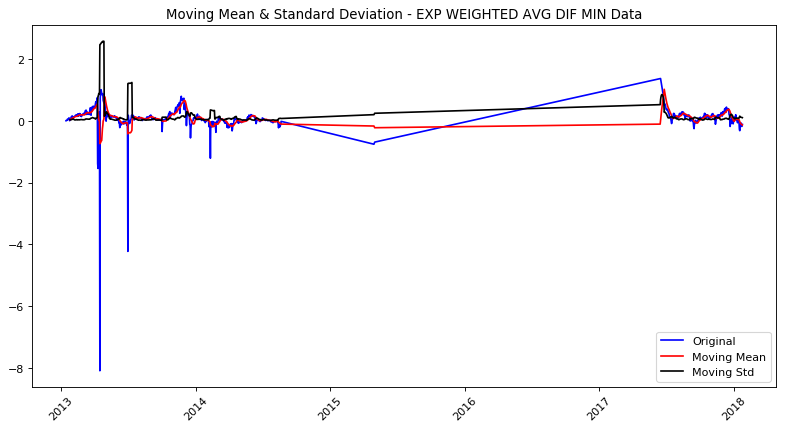

Results of Dickey-Fuller Test:
Test Statistic                -7.968428e+00
p-value                        2.823632e-12
#Lags Used                     7.000000e+00
Number of Observations Used    8.030000e+02
Critical Value (5%)           -2.865146e+00
Critical Value (1%)           -3.438520e+00
Critical Value (10%)          -2.568690e+00
dtype: float64


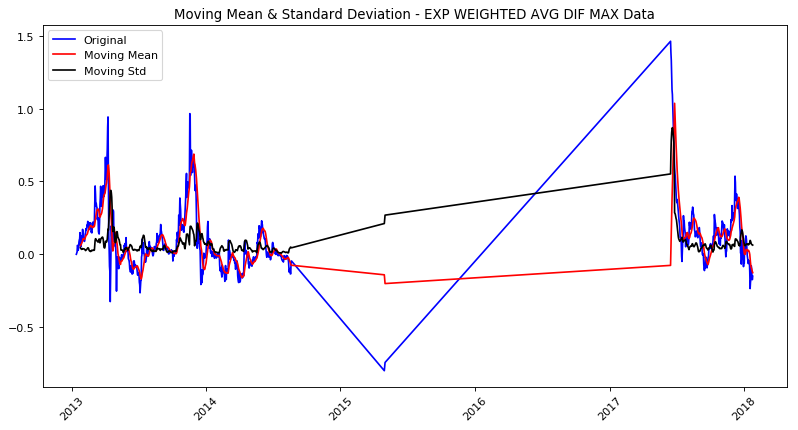

Results of Dickey-Fuller Test:
Test Statistic                  -5.429598
p-value                          0.000003
#Lags Used                       2.000000
Number of Observations Used    808.000000
Critical Value (5%)             -2.865124
Critical Value (1%)             -3.438469
Critical Value (10%)            -2.568678
dtype: float64
############################################################
THIS IS THE STATIONARITY TEST REPORT
NULL HYPOTHESIS SUCCESSFULLY REJECTED FOR DATA EXP WEIGHTED AVG DIF MIN. DATA IS STATIONARY
NULL HYPOTHESIS SUCCESSFULLY REJECTED FOR DATA EXP WEIGHTED AVG DIF MAX. DATA IS STATIONARY
############################################################


In [12]:
#checking stationarity with ewma
expDiffLogMinFuller, expDiffLogMinData= computeDiffLog(aggDataArimaMinLog, expMeanAggDataArimaMinLog, 'EXP WEIGHTED AVG DIF MIN', dateTicks)
expDiffLogMaxFuller, expDiffLogMaxData = computeDiffLog(aggDataArimaMaxLog, expMeanAggDataArimaMaxLog, 'EXP WEIGHTED AVG DIF MAX', dateTicks)
stationarityCheckReport([expDiffLogMinFuller, expDiffLogMaxFuller], ['EXP WEIGHTED AVG DIF MIN', 'EXP WEIGHTED AVG DIF MAX'])

In [88]:
import tabulate
#comparing all the results
table = [
             ['', 'p-value', 't-statistic'],
             ['MIN DATA','',''],
             ["Raw",fullerTestMin[1],fullerTestMin[0]],
             ["Log Transformed Data",fullerTestLogMin[1],fullerTestLogMin[0]],
             ["Moving avg - log(data)",meanDiffLogMinFuller[1],meanDiffLogMinFuller[0]],
             ["Exp Weighted Avg - log(data)",expDiffLogMinFuller[1],expDiffLogMinFuller[0]],
             ['MAX DATA','',''],
             ["Raw",fullerTestMax[1],fullerTestMax[0]],
             ["Log Transformed Data",fullerTestLogMax[1],fullerTestLogMax[0]],
             ["Moving avg - log(data)",meanDiffLogMaxFuller[1],meanDiffLogMaxFuller[0]],
             ["Exp Weighted Avg - log(data)",expDiffLogMaxFuller[1],expDiffLogMaxFuller[0]]
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))
print 'Best option = Moving Avg for both files'

Best option = Moving Avg for both files


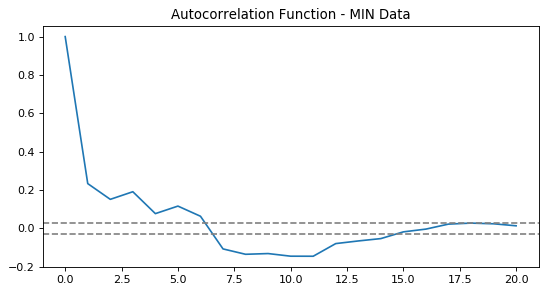

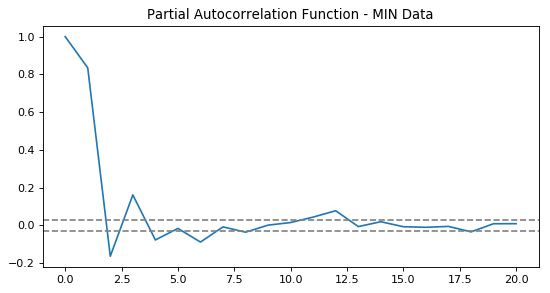

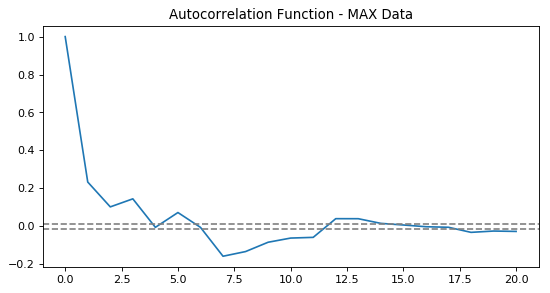

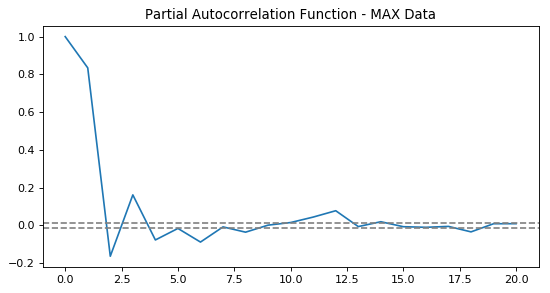

In [31]:
#plotting acf, pacf to find the best values for p and q in ARIMA
from statsmodels.tsa.stattools import acf, pacf
acfMeanDiffMin = acf(meanDiffLogMinData, nlags=20)
pacfMeanDiffMin = pacf(meanDiffLogMinData, nlags=20, method='ols')

acfMeanDiffMax = acf(meanDiffLogMaxData, nlags=20)
pacfMeanDiffMax = pacf(meanDiffLogMaxData, nlags=20, method='ols')

def calculateCI(zValue, data):
    std = numpy.std(data)
    mean = numpy.mean(data)
    ciPos = zValue * (std / numpy.sqrt(len(data)))
    ciNeg = -1 * ciPos
    return ciPos, ciNeg

def plotAcfPacf(dataGathered, titleAcf, titlePacf, ciNeg, ciPos):
    # dataGathered --> itarable of data to plot
    for i in range(len(dataGathered)):
        #Plot ACF:
        plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(dataGathered[0][i])
        plt.axhline(y=ciNeg[i],linestyle='--',color='gray')
        plt.axhline(y=ciPos[i],linestyle='--',color='gray')
        plt.title(titleAcf[i])
        plt.show()

        #Plot PACF
        plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(dataGathered[1][1])
        plt.axhline(y=ciNeg[i],linestyle='--',color='gray')
        plt.axhline(y=ciPos[i],linestyle='--',color='gray')
        plt.title(titlePacf[i])
        plt.show()

#calculating the confidence interval
ciPosMin, ciNegMin = calculateCI(1.96, meanDiffLogMinData)
ciPosMax, ciNegMax = calculateCI(1.96, meanDiffLogMaxData)

#plotting the pacf and acf graphs
plotAcfPacf([[acfMeanDiffMin, pacfMeanDiffMin], [acfMeanDiffMax, pacfMeanDiffMax]],
           titleAcf = ['Autocorrelation Function - MIN Data','Autocorrelation Function - MAX Data'],
           titlePacf = ['Partial Autocorrelation Function - MIN Data','Partial Autocorrelation Function - MAX Data'],
           ciNeg = [ciNegMin, ciNegMax],
           ciPos = [ciPosMin, ciPosMax])


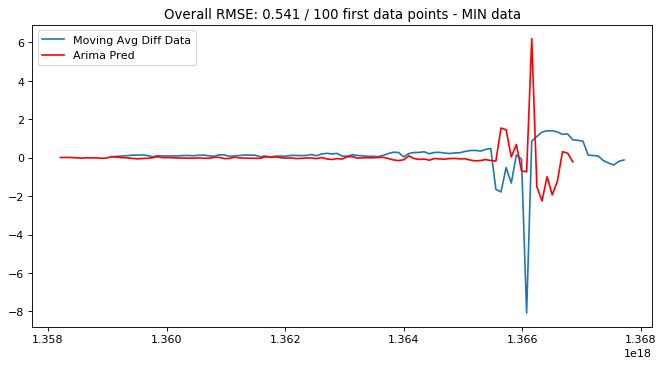

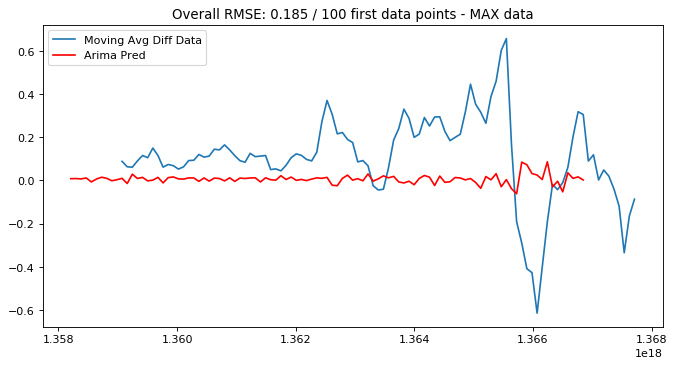

In [404]:
from sklearn.metrics import mean_squared_error
#upper confidence interval crossing points:
#MIN data --> order=(6,1,2)
#Max data --> order=(4,1,2)

arimaModelMin = ARIMA(aggDataArimaMinLog, order=(6, 1, 2))  
arimaModelMinFit = arimaModelMin.fit(disp=-1)  
arimaModelMax = ARIMA(aggDataArimaMaxLog, order=(4, 1, 2))  
arimaModelMaxFit = arimaModelMax.fit(disp=-1)  

rmseMin = numpy.sqrt(mean_squared_error(meanDiffLogMinData.as_matrix(), arimaModelMinFit.fittedvalues[10:]))
rmseMax = numpy.sqrt(mean_squared_error(meanDiffLogMaxData.as_matrix(), arimaModelMaxFit.fittedvalues[10:]))

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(meanDiffLogMinData[0:101], label = 'Moving Avg Diff Data')
plt.plot(arimaModelMinFit.fittedvalues[0:101], color='red', label = 'Arima Pred')
plt.legend(loc='best')
plt.title('Overall RMSE: ' + str(round(rmseMin,3)) + ' / 100 first data points - MIN data')
plt.show()

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(meanDiffLogMaxData[0:101], label = 'Moving Avg Diff Data')
plt.plot(arimaModelMaxFit.fittedvalues[0:101], color='red', label = 'Arima Pred')
plt.title('Overall RMSE: ' + str(round(rmseMax,3)) + ' / 100 first data points - MAX data')
plt.legend(loc='best')
plt.show()

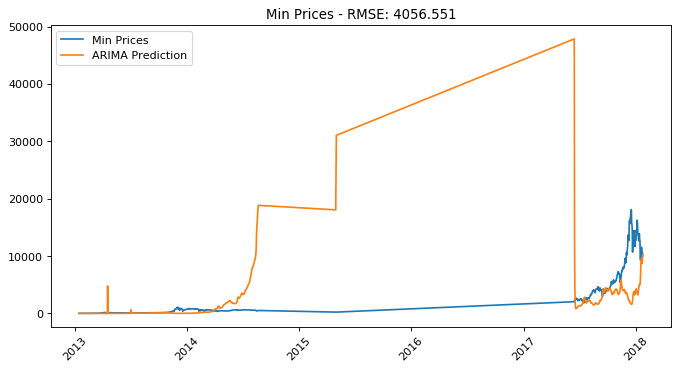

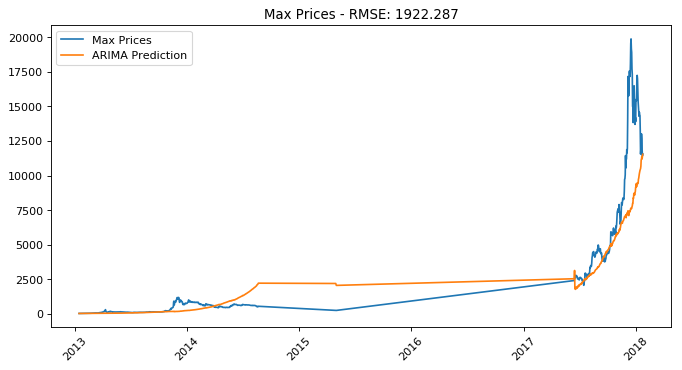

In [249]:
#returning to the original data checkpoint
arimaMinDiff = pandas.Series(arimaModelMinFit.fittedvalues, copy=True)
arimaMaxDiff = pandas.Series(arimaModelMaxFit.fittedvalues, copy=True)
#print ArimaMinDiff.head()
#print ArimaMaxDiff.head()

arimaMinDiffCumSum = arimaMinDiff.cumsum()
arimaMaxDiffCumSum = arimaMaxDiff.cumsum()
#print ArimaMinDiffCumSum.head()
#print ArimaMaxDiffCumSum.head()

arimaMinDiffLog = pandas.Series(aggDataArimaMinLog.ix[0], index=aggDataArimaMinLog.index)
arimaMaxDiffLog = pandas.Series(aggDataArimaMaxLog.ix[0], index=aggDataArimaMaxLog.index)
arimaMinDiffLog = arimaMinDiffLog.add(arimaMinDiffCumSum,fill_value=0)
arimaMaxDiffLog = arimaMaxDiffLog.add(arimaMaxDiffCumSum,fill_value=0)
#print arimaMinDiffLog.head()
#print arimaMaxDiffLog.head()

predictionsNormalBaseMin = numpy.exp(arimaMinDiffLog)
predictionsNormalBaseMax = numpy.exp(arimaMaxDiffLog)

minRMSEFinal = numpy.sqrt(mean_squared_error(aggData['PRICE']['min'].as_matrix(), predictionsNormalBaseMin.as_matrix()))
maxRMSEFinal = numpy.sqrt(mean_squared_error(aggData['PRICE']['max'].as_matrix(), predictionsNormalBaseMax.as_matrix()))

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Min Prices - RMSE: " + str(round(minRMSEFinal,3)))
plt.plot(dateTicks, aggData['PRICE']['min'], label='Min Prices')
plt.plot(dateTicks, predictionsNormalBaseMin, label='ARIMA Prediction')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show(block=False)

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Max Prices - RMSE: " + str(round(maxRMSEFinal,3)))
plt.plot(dateTicks, aggData['PRICE']['max'], label='Max Prices')
plt.plot(dateTicks, predictionsNormalBaseMax, label='ARIMA Prediction')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show(block=False)

In [335]:
#prepating to fit lstm
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import random

def scaleData(data, feature_range=(0,1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    dataset = scaler.fit_transform(data.reshape(-1, 1))
    return dataset, scaler

def trainTestSplit(data, train_size=0.85):
    train_size = int(len(data) * train_size)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    return train, test

def reportData(trainMin, testMin, trainMax, testMax, scaledMin, scaledMax, aggDataFull, sep = '#', mult = 60):
    print sep * mult
    print 'SCALED DATA REPORT'
    print 'Training data for MIN values size: ' + str(len(trainMin))
    print 'Testing data for MIN values size: ' + str(len(testMin))
    print 'Training data for MAX values size: ' + str(len(trainMax))
    print 'Testing data for MAX values size: ' + str(len(testMax))
    print 'Minimum, Maximum values for scaled MIN data: ' + str(min(scaledMin)), str(max(scaledMin))
    print 'Minimum, Maximum values for scaled MAX data: ' + str(min(scaledMax)), str(max(scaledMax))
    print sep * mult
    
scaledMin, scalerMin = scaleData(aggDataLSTMMin)
scaledMax, scalerMax = scaleData(aggDataLSTMMax)
trainMin, testMin = trainTestSplit(scaledMin)
trainMax, testMax = trainTestSplit(scaledMax)

#report
reportData(trainMin, testMin, trainMax, testMax, scaledMin, scaledMax, aggData)

############################################################
SCALED DATA REPORT
Training data for MIN values size: 689
Testing data for MIN values size: 122
Training data for MAX values size: 689
Testing data for MAX values size: 122
Minimum, Maximum values for scaled MIN data: [ 0.] [ 1.]
Minimum, Maximum values for scaled MAX data: [ 0.] [ 1.]
############################################################


In [137]:
# convert an array of values into a dataset matrix
def createDataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
look_back=1
#for min values
trainMinX, trainMinY = create_dataset(trainMin, look_back)
testMinX, testMinY = create_dataset(testMin, look_back)
#for max values
trainMaxX, trainMaxY = create_dataset(trainMax, look_back)
testMaxX, testMaxY = create_dataset(testMax, look_back)

# reshape input to be [samples, time steps, features]
#for min values
trainMinX = numpy.reshape(trainMinX, (trainMinX.shape[0], 1, trainMinX.shape[1]))
testMinX = numpy.reshape(testMinX, (testMinX.shape[0], 1, testMinX.shape[1]))

# reshape input to be [samples, time steps, features]
#for max values
trainMaxX = numpy.reshape(trainMaxX, (trainMaxX.shape[0], 1, trainMaxX.shape[1]))
testMaxX = numpy.reshape(testMaxX, (testMaxX.shape[0], 1, testMaxX.shape[1]))

def modelCreator(layer1LSTM=256, layer2LSTM=128, dense1=32, initDense1 = 'uniform',  activationDense1 = 'relu',
                 loss='mean_squared_error', optimizer='adam', lookback=1):
    model = Sequential()
    model.add(LSTM(layer1LSTM, input_shape=(1, look_back), return_sequences=True))
    model.add(LSTM(layer2LSTM, input_shape=(1, look_back), return_sequences=False))
    model.add(Dense(32,init=initDense1,activation=activationDense1))
    model.add(Dense(1,init='uniform',activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

modelMin = modelCreator()
modelMax = modelCreator()

modelMin.fit(trainMinX, trainMinY, epochs=500, batch_size=100, verbose=0)
modelMax.fit(trainMaxX, trainMaxY, epochs=500, batch_size=100, verbose=0)

Train Score Min Data: 105.64 RMSE
Test Score Min Data: 1093.37 RMSE
Train Score Max Data: 92.59 RMSE
Test Score Max Data: 858.70 RMSE


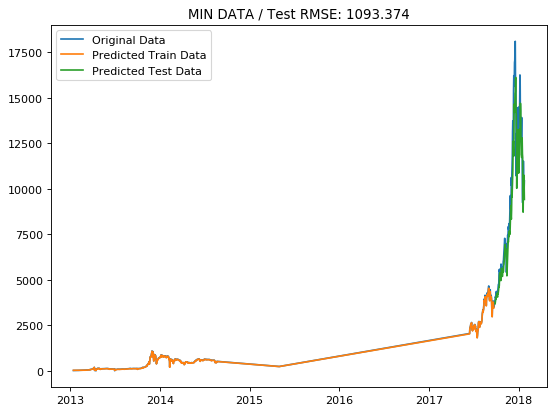

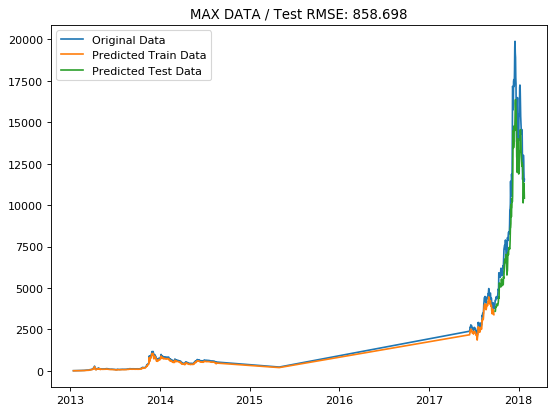

In [381]:
# make predictions

#for min values
trainPredictMin = modelMin.predict(trainMinX)
testPredictMin = modelMin.predict(testMinX)

#for max values
trainPredictMax = modelMax.predict(trainMaxX)
testPredictMax = modelMax.predict(testMaxX)

def invertPred(scaler, ds1, ds2):
    scaled1 = scalerMin.inverse_transform(ds1)
    scaled2 = scalerMin.inverse_transform([ds2])
    return scaled1, scaled2

def calculateRMSE(dsY, ds):
    rmse = math.sqrt(mean_squared_error(dsY[0], ds[:,0]))
    return rmse

# invert predictions
#for min data
trainPredictMin, trainMinYInv = invertPred(scalerMin, trainPredictMin, trainMinY)
testPredictMin, testMinYInv = invertPred(scalerMin, testPredictMin, testMinY)
#for max data
trainPredictMax, trainMaxYInv = invertPred(scalerMax, trainPredictMax, trainMaxY)
testPredictMax, testMaxYInv = invertPred(scalerMax, testPredictMax, testMaxY)

# calculate root mean squared error
#for min data
trainScoreMin = calculateRMSE(trainMinYInv, trainPredictMin)
print('Train Score Min Data: %.2f RMSE' % (trainScoreMin))
testScoreMin = calculateRMSE(testMinYInv, testPredictMin)
print('Test Score Min Data: %.2f RMSE' % (testScoreMin))
#for max data
trainScoreMax = calculateRMSE(trainMaxYInv, trainPredictMax)
print('Train Score Max Data: %.2f RMSE' % (trainScoreMax))
testScoreMax = calculateRMSE(testMaxYInv, testPredictMax)
print('Test Score Max Data: %.2f RMSE' % (testScoreMax))

def makingPlot(dateTicks, dataset, train, test, scaler, testRmse, title):
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:] = numpy.nan
    trainPredictPlot[0:len(train)] = [x[0] for x in train.tolist()]
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:] = numpy.nan
    testPredictPlot[-len(test):] = [x[0] for x in test.tolist()]
    # plot baseline and predictions
    plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title + '/ Test RMSE: ' + str(round(testRmse, 3)))
    plt.plot(dateTicks, dataset, label='Original Data')
    plt.plot(dateTicks, trainPredictPlot, label='Predicted Train Data')
    plt.plot(dateTicks, testPredictPlot, label='Predicted Test Data')
    plt.legend(loc='best')
    plt.show()
    
#plot min data
makingPlot(dateTicks, aggDataLSTMMin, trainPredictMin, testPredictMin, scalerMin, testScoreMin, 'MIN DATA ')
#plot max data
makingPlot(dateTicks, aggDataLSTMMax, trainPredictMax, testPredictMax, scalerMax, testScoreMax, 'MAX DATA ')

In [228]:
#dummy model for comparison
from sklearn.dummy import DummyRegressor

trainDummyMin, testDummyMin = trainTestSplit(aggDataDummyMin.reshape(-1,1))
trainDummyMax, testDummyMax = trainTestSplit(aggDataDummyMax.reshape(-1,1))

def simpleReport(trainMin, testMin, trainMax, testMax, sep = '#', mult = 60):
    print sep * mult
    print 'DUMMY MODEL DATA REPORT'
    print 'Training data for MIN values size: ' + str(len(trainMin))
    print 'Testing data for MIN values size: ' + str(len(testMin))
    print 'Training data for MAX values size: ' + str(len(trainMax))
    print 'Testing data for MAX values size: ' + str(len(testMax))
    print sep * mult
    
#report
simpleReport(trainDummyMin, testDummyMin, trainDummyMax, testDummyMax)

############################################################
DUMMY MODEL DATA REPORT
Training data for MIN values size: 689
Testing data for MIN values size: 122
Training data for MAX values size: 689
Testing data for MAX values size: 122
############################################################


In [412]:
# dummy model fit
# for this model we will only capture the rmse of test dataset!!!
def dummyModelFit(strategy, ds1, ds2, quantile=0.75):
    model = DummyRegressor(strategy=strategy, quantile=quantile)
    model.fit(ds1, ds1)
    pred = model.predict(ds2)
    return model, pred
#for min values
meanDummyModelMin, meanDummyModelPredMin = dummyModelFit('mean', trainDummyMin, testDummyMin)
medianDummyModelMin, medianDummyModelPredMin = dummyModelFit('median', trainDummyMin, testDummyMin)
quantileDummyModelMin, quantileDummyModelPredMin = dummyModelFit('quantile', trainDummyMin, testDummyMin)

rmseMeanDummyModelMin = numpy.sqrt(mean_squared_error(testDummyMin, meanDummyModelPredMin))
rmseMedianDummyModelMin = numpy.sqrt(mean_squared_error(testDummyMin, medianDummyModelPredMin))
rmseQuantileDummyModelMin = numpy.sqrt(mean_squared_error(testDummyMin, quantileDummyModelPredMin))

#for max values
meanDummyModelMax, meanDummyModelPredMax = dummyModelFit('mean', trainDummyMax, testDummyMax)
medianDummyModelMax, medianDummyModelPredMax = dummyModelFit('median', trainDummyMax, testDummyMax)
quantileDummyModelMax, quantileDummyModelPredMax = dummyModelFit('quantile', trainDummyMax, testDummyMax)

rmseMeanDummyModelMax = numpy.sqrt(mean_squared_error(testDummyMax, meanDummyModelPredMax))
rmseMedianDummyModelMax = numpy.sqrt(mean_squared_error(testDummyMax, medianDummyModelPredMax))
rmseQuantileDummyModelMax = numpy.sqrt(mean_squared_error(testDummyMax, quantileDummyModelPredMax))

def reportDummyModel(meanDummyModelPredMin,
                     medianDummyModelPredMin,
                     quantileDummyModelPredMin,
                     meanDummyModelPredMax,
                     medianDummyModelPredMax,
                     quantileDummyModelPredMax,
                     sep='#', mult=60, title=['MIN DATA', 'MAX DATA']):
    print sep * mult
    print title[0]
    print 'Dummy Model Predicting Mean: ' + str(round(meanDummyModelPredMin[0][0]))
    print 'Dummy Model Predicting Median: ' + str(round(medianDummyModelPredMin[0][0]))
    print 'Dummy Model Predicting Quantile 75: ' + str(round(quantileDummyModelPredMin[0][0]))
    print title[1]
    print 'Dummy Model Predicting Mean: ' + str(round(meanDummyModelPredMax[0][0]))
    print 'Dummy Model Predicting Median: ' + str(round(medianDummyModelPredMax[0][0]))
    print 'Dummy Model Predicting Quantile 75: ' + str(round(quantileDummyModelPredMax[0][0]))
    print sep * mult
    
reportDummyModel(meanDummyModelPredMin,
                 medianDummyModelPredMin,
                 quantileDummyModelPredMin,
                 meanDummyModelPredMax,
                 medianDummyModelPredMax,
                 quantileDummyModelPredMax)

############################################################
MIN DATA
Dummy Model Predicting Mean: 753.0
Dummy Model Predicting Median: 444.0
Dummy Model Predicting Quantile 75: 651.0
MAX DATA
Dummy Model Predicting Mean: 820.0
Dummy Model Predicting Median: 478.0
Dummy Model Predicting Quantile 75: 740.0
############################################################


In [251]:
#final comparison
table = [
             ['', 'RMSE'],
             ['MIN DATA',''],
             ["ARIMA Model",round(minRMSEFinal,3)],
             ["LSTM",round(testScoreMin, 3)],
             ["Dummy Model - Mean",round(rmseMeanDummyModelMin,3)],
             ["Dummy Model - Median",round(rmseMedianDummyModelMin,3)],
             ["Dummy Model - Quantile 75",round(rmseQuantileDummyModelMin,3)],
             ['MAX DATA',''],
             ["ARIMA Model",round(maxRMSEFinal,3)],
             ["LSTM",round(testScoreMax,3)],
             ["Dummy Model - Mean",round(rmseMeanDummyModelMax,3)],
             ["Dummy Model - Median",round(rmseMedianDummyModelMax,3)],
             ["Dummy Model - Quantile 75",round(rmseQuantileDummyModelMax,3)],
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))
print 'Best option = LSTM'


Best option = LSTM


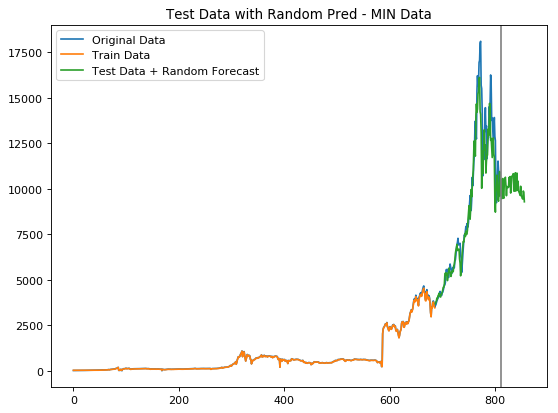

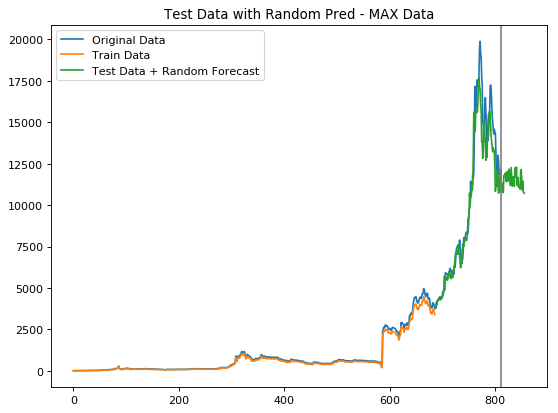

In [395]:
# this section is done to add more data into the series to emulate future values
# the window is 12, as the previous ones
def inputFutureData(testData, numberOfInsertions = 50, window = 12, percentageRandomicity = 0.05):
    testDataInsider = deepcopy(testData)
    for i in range(numberOfInsertions):
        #introducing randomicity, 0 or 5% of max value in the window cut
        epsilon = []
        epsilon.append(0)
        epsilon.append(percentageRandomicity * max(testDataInsider[-window:]))
        epsilon.append(-1 * percentageRandomicity * max(testDataInsider[-window:]))
        testDataInsider = numpy.append(testDataInsider, numpy.mean(testDataInsider[-window:]) + random.choice(epsilon)) 
    return testDataInsider.reshape(-1,1)

#for min data
forecastedLSTMMin = inputFutureData(testMin)
testForecastedMinX, testForecastedMinY = create_dataset(forecastedLSTMMin, look_back)
testForecastedMinX = numpy.reshape(testForecastedMinX, (testForecastedMinX.shape[0], 1, testForecastedMinX.shape[1]))
testPredictForecastedMin = modelMin.predict(testForecastedMinX)
testPredictForecastedMin = scalerMin.inverse_transform(testPredictForecastedMin)
totalLen = len(trainPredictMin) + len(testPredictForecastedMin)
aggDataLSTMMinForecastedPlot = numpy.append(aggDataLSTMMin, [numpy.nan for x in range(totalLen - len(aggDataLSTMMin))])
trainPredictMinForecastedPlot = numpy.append(trainPredictMin, [numpy.nan for x in range(totalLen - len(trainPredictMin))])
testPredictForecastedMinPlot = numpy.array([numpy.nan for x in range(totalLen - len(testPredictForecastedMin))])
testPredictForecastedMinPlot = numpy.append(testPredictForecastedMinPlot, testPredictForecastedMin)
#plot
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Test Data with Random Pred - MIN Data')
plt.plot(aggDataLSTMMinForecastedPlot, label = 'Original Data')
plt.plot(trainPredictMinForecastedPlot, label = 'Train Data')
plt.plot(testPredictForecastedMinPlot, label = 'Test Data + Random Forecast')
plt.legend(loc='best')
plt.axvline(x=len(aggDataLSTMMin), color ='gray')
plt.show()

#for max data
forecastedLSTMMax = inputFutureData(testMax)
testForecastedMaxX, testForecastedMaxY = create_dataset(forecastedLSTMMax, look_back)
testForecastedMaxX = numpy.reshape(testForecastedMaxX, (testForecastedMaxX.shape[0], 1, testForecastedMaxX.shape[1]))
testPredictForecastedMax = modelMin.predict(testForecastedMaxX)
testPredictForecastedMax = scalerMax.inverse_transform(testPredictForecastedMax)
totalLen = len(trainPredictMax) + len(testPredictForecastedMax)
aggDataLSTMMaxForecastedPlot = numpy.append(aggDataLSTMMax, [numpy.nan for x in range(totalLen - len(aggDataLSTMMax))])
trainPredictMaxForecastedPlot = numpy.append(trainPredictMax, [numpy.nan for x in range(totalLen - len(trainPredictMax))])
testPredictForecastedMaxPlot = numpy.array([numpy.nan for x in range(totalLen - len(testPredictForecastedMax))])
testPredictForecastedMaxPlot = numpy.append(testPredictForecastedMaxPlot, testPredictForecastedMax)
#plot
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Test Data with Random Pred - MAX Data')
plt.plot(aggDataLSTMMaxForecastedPlot, label = 'Original Data')
plt.plot(trainPredictMaxForecastedPlot, label = 'Train Data')
plt.plot(testPredictForecastedMaxPlot, label = 'Test Data + Random Forecast')
plt.legend(loc='best')
plt.axvline(x=len(aggDataLSTMMax), color ='gray')
plt.show()